
# How does the shape / size of our network affect its ability to learn?

Using TensorFlow backend.


sorting data by tag
308955
303925
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 21)                462       
_________________________________________________________________
dense_9 (Dense)              (None, 700)               15400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 700)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 500)               350500    
_________________________________________________________________
dropout_2 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 300)               150300    
_________________________________________________________________
dropout_3 (Dropout) 

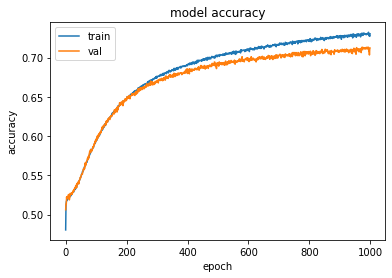

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="6"
from keras.models import Sequential
from keras.optimizers import Adam
from keras.regularizers import l1
from keras.layers import Dense, Conv2D, Flatten, Dropout
import ptetaphi_nn
import tools
with open("filepath.txt", 'r') as f:
    filename = f.read()
    
s_table = tools.open_file(filename, sort_by="tag")
# filter by realistic situation where we have 3 tags and 3 or 4 jets.
# ignore the case where there may be >4 since those are pretty rare
nb4 = (s_table.nbjets == 3) | (s_table.nbjets == 4) # 3 or 4 b-jets exist
nt3 = s_table.nbtags==3  # 3 b tags
nb4nt3 = nb4 & nt3
events = s_table[nb4nt3]
print(len(events))

# and ensure that the 3 tags are actually correct
# this results in very little event loss
events = events[events.truth[:,0] == 1]
events = events[events.truth[:,1] == 1]
events = events[events.truth[:,2] == 1]
print(len(events))

cutoff = 10  # not many events have >10 jets
# "pad" = ensure all events have same length, cut off ends if needed
events = tools.pad(events, cutoff)

import importlib
importlib.reload(ptetaphi_nn)
nn = ptetaphi_nn.PtEtaPhiNN(events)
# Feed forward NN

# create network
nn.model = Sequential([
    Dense(3*(cutoff-3), input_dim=3*(cutoff-3), kernel_initializer='normal', activation='relu'),
    Dense(700, activation='relu'),
    Dropout(0.1),
    Dense(500, activation='relu'),
    Dropout(0.1),
    Dense(300, activation='relu'),
    Dropout(0.1),
    Dense(100, activation='relu'),
    Dropout(0.1),
    Dense( 50, activation='relu'),
    Dense(8, kernel_initializer='normal', activation='softmax')])
nn.model.compile(loss='categorical_crossentropy',
                 optimizer="adam", metrics=['acc'])
nn.model.summary()
nn.learn(epochs=1000)


using data given when this model was created


100%|██████████| 60785/60785 [00:00<00:00, 110594.95it/s]


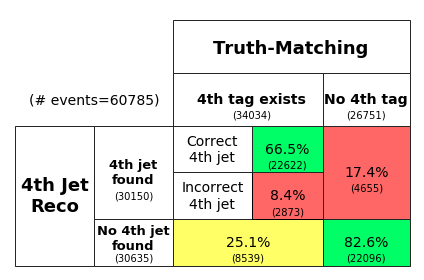

In [5]:
nn.evaluate(savename="2b")

In [6]:
nn.model.save("bbb_model_dropout.json")
# when the model was exported no regularization was done